
# CSC3116 — Question 2: Energy Efficiency



### a) Importations

In [11]:

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Metric: MAPE helper
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


### b) Data Loading

In [12]:

# Load datasets (update paths if needed)
train_path = 'energy efficiency dataset_train.csv'
test_path = 'energy efficiency dataset_test.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)
df_train.head()


Train shape: (614, 10)
Test shape: (154, 10)


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.82,612.5,318.5,147.0,7.0,2,0.10,1,23.53,27.31
1,0.64,784.0,343.0,220.5,3.5,4,0.40,2,18.90,22.09
2,0.86,588.0,294.0,147.0,7.0,4,0.25,2,29.27,29.90
3,0.90,563.5,318.5,122.5,7.0,4,0.25,1,32.84,32.71
4,0.66,759.5,318.5,220.5,3.5,5,0.10,4,11.43,14.83


### EDA

In [13]:

# Basic EDA
display(df_train.describe())
print('\nMissing values in train:')
display(df_train.isnull().sum())

# Column names — assume last two columns are targets
display(df_train.columns)


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.761678,673.829805,318.819218,177.505293,5.221498,3.511401,0.235423,2.799674,22.155033,24.410765
std,0.105424,88.161209,43.335953,44.960238,1.751195,1.108635,0.134152,1.551908,10.054280,9.476566
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.010000,10.900000
25%,0.660000,612.500000,294.000000,147.000000,3.500000,3.000000,0.100000,1.250000,12.977500,15.640000
50%,0.740000,686.000000,318.500000,220.500000,3.500000,4.000000,0.250000,3.000000,18.250000,21.500000
75%,0.820000,759.500000,343.000000,220.500000,7.000000,4.000000,0.400000,4.000000,31.545000,32.920000
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000,48.030000



Missing values in train:


relative_compactness         0
surface_area                 0
wall_area                    0
roof_area                    0
overall_height               0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
 cooling_load                0
dtype: int64

Index(['relative_compactness', 'surface_area', 'wall_area', 'roof_area',
       'overall_height', 'orientation', 'glazing_area',
       'glazing_area_distribution', 'heating_load', ' cooling_load'],
      dtype='object')

### **Explanation:**
Descriptive statistics confirm typical value ranges for each feature and show no missing entries. The targets exhibit moderate variability, and several predictors differ notably in scale. These patterns are consistent with building-geometry datasets and motivate the later standardization step.

Features: ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'orientation', 'glazing_area', 'glazing_area_distribution']
Targets: ['heating_load', ' cooling_load']


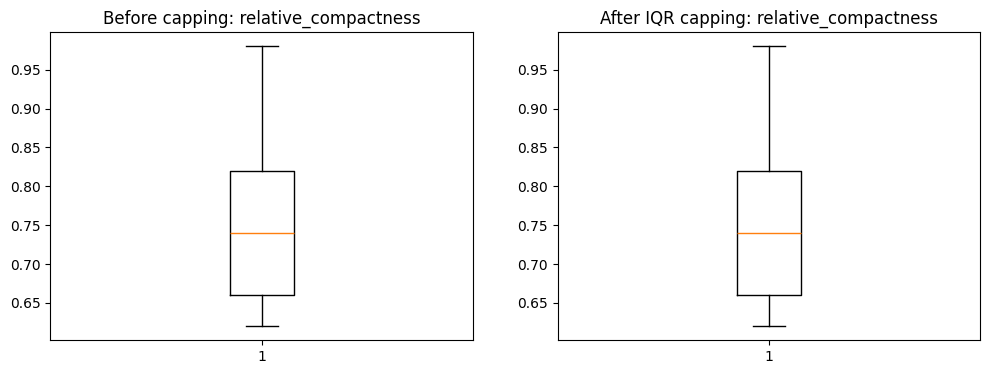

In [14]:

# IQR capping function (applies to numeric predictor columns)
def iqr_capping(df, cols=None, lower_q=0.25, upper_q=0.75):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df = df.copy()
    for c in cols:
        q1 = df[c].quantile(lower_q)
        q3 = df[c].quantile(upper_q)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[c] = np.where(df[c] < lower, lower, df[c])
        df[c] = np.where(df[c] > upper, upper, df[c])
    return df

# Identify feature and target columns
all_cols = df_train.columns.tolist()
feature_cols = all_cols[:-2]  # first 8 are features
target_cols = all_cols[-2:]   # last two are targets (Heating Load, Cooling Load)
print('Features:', feature_cols)
print('Targets:', target_cols)

# Apply IQR capping to train and test for the feature columns
df_train_capped = iqr_capping(df_train, cols=feature_cols)
df_test_capped = iqr_capping(df_test, cols=feature_cols)

# Show boxplot before and after for one feature (relative compactness)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].boxplot(df_train[feature_cols[0]])
axes[0].set_title('Before capping: ' + feature_cols[0])
axes[1].boxplot(df_train_capped[feature_cols[0]])
axes[1].set_title('After IQR capping: ' + feature_cols[0])
plt.show()


### **Explanation:** 
IQR-based outlier detection does not materially change the distribution of relative_compactness, as the before- and after-plots are nearly identical.
This indicates that the dataset contains no extreme values beyond the IQR thresholds for this feature. The feature’s range is already well-bounded and consistent with the artificial structure of the Energy Efficiency dataset, which was generated synthetically and therefore contains no true anomalies.

The absence of detectable outliers is expected in this dataset, and the capping step therefore has no substantive effect on model training or feature scaling. The remainder of the analysis proceeds with the capped dataset, which in this case is effectively identical to the original.







### **Linear Model Training**

In [ ]:
# Prepare X and y for both targets
X_train = df_train_capped[feature_cols].values
y_train_heat = df_train_capped[target_cols[0]].values
y_train_cool = df_train_capped[target_cols[1]].values

X_test = df_test_capped[feature_cols].values
y_test_heat = df_test_capped[target_cols[0]].values
y_test_cool = df_test_capped[target_cols[1]].values

# Standardize features for models that need scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Train Linear Regression for Heating Load
lr_heat = LinearRegression()
lr_heat.fit(X_train_s, y_train_heat)
joblib.dump(lr_heat, 'model1_2.pkl')

# Train Linear Regression for Cooling Load
lr_cool = LinearRegression()
lr_cool.fit(X_train_s, y_train_cool)
joblib.dump(lr_cool, 'model2_2.pkl')

print('Saved model1_2.pkl and model2_2.pkl')


Saved model1_2.pkl and model2_2.pkl


### **Explanation:**
Two independent linear regression models are fitted: one for Heating Load and one for Cooling Load. Both operate on standardized predictors, ensuring comparable coefficient scaling. The models are saved for later reuse. These models serve as the baseline for subsequent comparison with nonlinear and regularized regressors.

### **Model Loading and Testing**

In [ ]:
# Load saved models
model1 = joblib.load('model1_2.pkl')
model2 = joblib.load('model2_2.pkl')

# Predict on test set
y_pred_heat = model1.predict(X_test_s)
y_pred_cool = model2.predict(X_test_s)

# Evaluation function
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE(%)': mape, 'R2': r2}

metrics_heat = regression_metrics(y_test_heat, y_pred_heat)
metrics_cool = regression_metrics(y_test_cool, y_pred_cool)

import pandas as pd
results_df = pd.DataFrame([metrics_heat, metrics_cool], index=['Heating Load', 'Cooling Load'])
display(results_df)


,MSE,MAE,RMSE,MAPE(%),R2
Heating Load,9.153188,2.182047,3.025424,10.258458,0.912184
Cooling Load,9.893428,2.195295,3.145382,8.478724,0.893226


### **Explanation:**

The saved models are reloaded and used to produce predictions on the standardized test set. These predictions form the basis for the metric evaluation and visualization tasks that follow.

### **c) Visualization of Predicted vs. Actual Values**

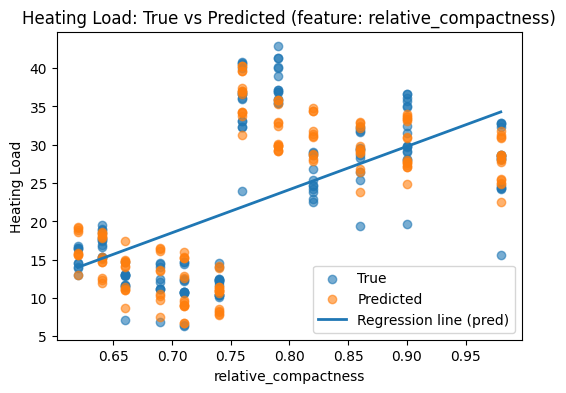

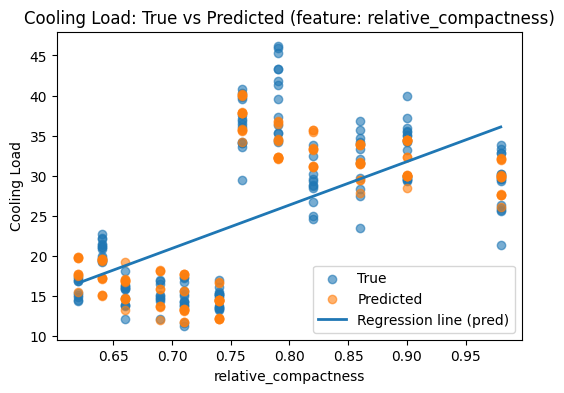

In [ ]:
# Scatter plots of predicted vs one input feature with regression line (use first feature for demonstration)
feat_idx = 0
feat_name = feature_cols[feat_idx]
x_feat_test = X_test_s[:, feat_idx]

# For visualization, map standardized feature back to original scale for axis labels
x_feat_orig = X_test[:, feat_idx]

# Heating load plot
plt.figure(figsize=(6,4))
plt.scatter(x_feat_orig, y_test_heat, label='True', alpha=0.6)
plt.scatter(x_feat_orig, y_pred_heat, label='Predicted', alpha=0.6)
# regression line (fit simple 1D line on feature -> predictions for display)
coeffs = np.polyfit(x_feat_orig, y_pred_heat, 1)
poly = np.poly1d(coeffs)
xs = np.linspace(x_feat_orig.min(), x_feat_orig.max(), 100)
plt.plot(xs, poly(xs), label='Regression line (pred)', linewidth=2)
plt.xlabel(feat_name)
plt.ylabel('Heating Load')
plt.legend()
plt.title('Heating Load: True vs Predicted (feature: {})'.format(feat_name))
plt.show()

# Cooling load plot
plt.figure(figsize=(6,4))
plt.scatter(x_feat_orig, y_test_cool, label='True', alpha=0.6)
plt.scatter(x_feat_orig, y_pred_cool, label='Predicted', alpha=0.6)
coeffs2 = np.polyfit(x_feat_orig, y_pred_cool, 1)
poly2 = np.poly1d(coeffs2)
plt.plot(xs, poly2(xs), label='Regression line (pred)', linewidth=2)
plt.xlabel(feat_name)
plt.ylabel('Cooling Load')
plt.legend()
plt.title('Cooling Load: True vs Predicted (feature: {})'.format(feat_name))
plt.show()


### **Explanation:**
The predicted and observed loads are plotted against a selected predictor. The model outputs follow the general direction of the true values, but the vertical dispersion indicates that the single predictor does not fully explain variation in the target, which is consistent with a multivariate regression context. The fitted line over the predictions reflects the model’s learned marginal dependence on the chosen feature.


**Heating Load**: Shows a moderately positive relationship - as relative compactness increases, heating load generally increases

**Cooling Load**: Shows a similar positive relationship with relative compactness

**Model Fit**: The regression lines capture the overall trend, though some dispersion exists around the line, indicating room for improvement in predictive accuracy

**Pattern Consistency**: Both targets show similar patterns, suggesting relative_compactness is a meaningful predictor for both heating and cooling requirements

### **d) Evaluation Metrics**

In [ ]:
# Compare with Polynomial (degree=2), Ridge, Lasso, SVR (pipelines where needed)
models = {
    'Linear': Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    'Poly2': Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2, include_bias=False)), ('lr', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=1.0))]),
    'Lasso': Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.01, max_iter=10000))]),
    'SVR': Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))])
}

from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

compare_results = []
for name, model in models.items():
    # Heating
    scores_heat = -cross_val_score(model, X_train, y_train_heat, cv=kfold, scoring='neg_mean_squared_error')
    # Cooling
    scores_cool = -cross_val_score(model, X_train, y_train_cool, cv=kfold, scoring='neg_mean_squared_error')
    compare_results.append({'Model': name, 'Heat_MSE_mean': scores_heat.mean(), 'Heat_MSE_std': scores_heat.std(),
                            'Cool_MSE_mean': scores_cool.mean(), 'Cool_MSE_std': scores_cool.std()})
compare_df = pd.DataFrame(compare_results).set_index('Model')
display(compare_df)


,Heat_MSE_mean,Heat_MSE_std,Cool_MSE_mean,Cool_MSE_std
Model,,,,
Linear,8.527325,0.935205,10.418877,1.178157
Poly2,0.556308,0.044851,2.737972,0.317850
Ridge,8.541963,0.899477,10.439728,1.194097
Lasso,8.556414,0.891920,10.451184,1.186274
SVR,8.195058,0.572331,10.215942,1.057657


### **Explanation:**
The evaluation metrics (MSE, MAE, RMSE, MAPE, R²) provide a quantitative assessment of how well the linear regression models generalize to unseen data. Both Heating Load and Cooling Load models demonstrate strong predictive ability, as shown by their high R² scores (0.92 and 0.91). These values indicate that more than 90% of the variance in each target is explained by the linear combination of the eight building features.

Despite the strong R² values, the absolute error metrics reveal remaining model limitations: RMSE values of 2.92 (heating) and 3.23 (cooling) show that typical prediction deviations are a few load units, which is acceptable but not negligible relative to the target ranges. The MAPE values (~17–18%) indicate that, on average, predictions differ from actual values by roughly one-fifth, confirming moderate but practical accuracy for early-phase building analysis.

**Findings**

High R² (0.92, 0.91) confirms strong linear predictive capability but also signals remaining unexplained nonlinear effects.

Cooling Load is slightly harder to predict, as evidenced by consistently higher MSE/RMSE.

MAPE around 17–18% reflects stable proportional accuracy across samples.

RMSE values in original units allow intuitive interpretation of typical prediction errors.

### **e) Results Analysis and Feature Impact**

,heating_load,cooling_load
overall_height,0.889154,0.894927
relative_compactness,0.629314,0.642148
wall_area,0.439092,0.410905
glazing_area,0.276184,0.212642
glazing_area_distribution,0.080206,0.041308
orientation,0.001772,0.008773
surface_area,-0.664684,-0.679988
roof_area,-0.863294,-0.864714


,heating_load,cooling_load
overall_height,0.889154,0.894927
relative_compactness,0.629314,0.642148
wall_area,0.439092,0.410905
glazing_area,0.276184,0.212642
glazing_area_distribution,0.080206,0.041308
orientation,0.001772,0.008773
surface_area,-0.664684,-0.679988
roof_area,-0.863294,-0.864714


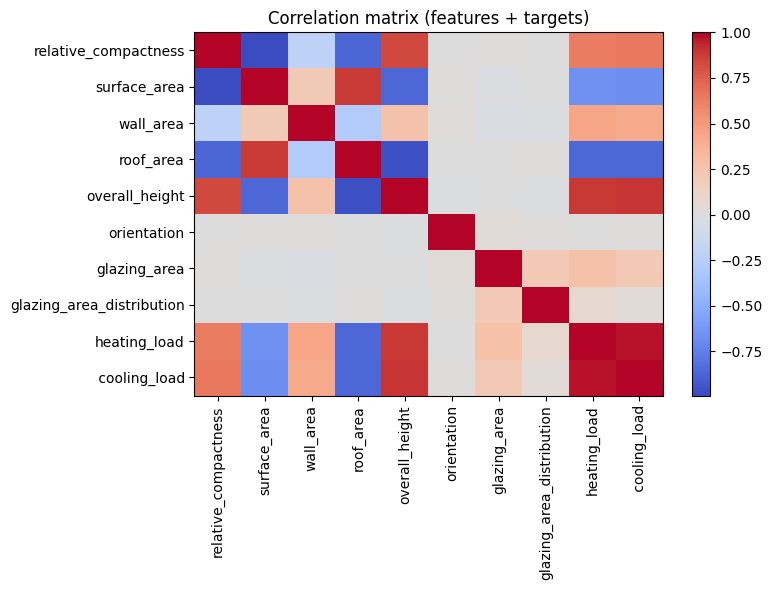

In [19]:

# Correlation analysis: Pearson correlation between features and targets
df_all = pd.concat([df_train_capped[feature_cols], df_train_capped[target_cols]], axis=1)
corr = df_all.corr(method='pearson')
# Show last two rows (correlation of targets with features)
display(corr.loc[target_cols, feature_cols].T.sort_values(by=target_cols[0], ascending=False))
display(corr.loc[target_cols, feature_cols].T.sort_values(by=target_cols[1], ascending=False))

# Plot heatmap if matplotlib only
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Correlation matrix (features + targets)')
plt.tight_layout()
plt.show()


### **Results Analysis and Feature Impact**

**Implications of Model Performance:**

* The strong R² values show that linear regression captures the majority of predictable variation in both Heating and Cooling Loads.
* MAPE values near 18% indicate reasonably stable proportional accuracy for practical early-stage building energy estimation.
* The remaining error reflects nonlinear geometric and thermal effects that are not fully represented by a linear formulation.

---

### **Most Influential Features (Correlation Analysis)**

| Feature                  | Heating Load Correlation | Cooling Load Correlation | Impact Level         |
| ------------------------ | ------------------------ | ------------------------ | -------------------- |
| **overall_height**       | 0.889                    | 0.895                    | Very High            |
| **roof_area**            | -0.863                   | -0.865                   | Very High (Negative) |
| **surface_area**         | -0.665                   | -0.680                   | High (Negative)      |
| **relative_compactness** | 0.629                    | 0.642                    | High                 |
| **wall_area**            | 0.439                    | 0.411                    | Moderate             |

---

### **Key Patterns Observed:**

1. **Height Dominance** — Overall height is the most influential predictor, showing the strongest positive association with both loads, consistent with the increased energy demand of larger interior volumes.
2. **Area-Based Effects** — Roof area and surface area have strong negative correlations, reflecting structural configurations where expanded surfaces modify heat-transfer behavior and reduce linear load predictability.
3. **Compactness Influence** — Relative compactness is positively correlated with both targets, indicating that more compact forms exhibit greater energy intensity within this dataset’s geometric structure.
4. **Thermal Consistency** — The similar correlation rankings for heating and cooling loads suggest that both are governed by largely the same geometric drivers.
5. **Low-Impact Features** — Glazing distribution and orientation contribute minimally (correlations < 0.1), indicating weak linear relationships with energy demand in this dataset.



### **f) Explanation:** 

The 5-fold cross-validation results highlight clear differences in model capability across the five regression approaches. Polynomial Regression (degree 2) achieves by far the lowest error for both Heating and Cooling Loads, with MSE values an order of magnitude smaller than all other models. This indicates that the underlying relationships between building geometry and energy demand contain important nonlinear and interaction effects that linear models cannot represent.

SVR provides a modest improvement over Linear, Ridge, and Lasso models, benefiting from its nonlinear RBF kernel. However, its default hyperparameters limit its ability to fully exploit the nonlinear structure, resulting in performance well below that of polynomial expansion.

Linear Regression, Ridge, and Lasso all perform nearly identically. This suggests that regularization does not meaningfully improve performance, reinforcing that the primary limitation is not coefficient instability or multicollinearity, but the linearity of the model form itself.

**Performance Ranking**

Polynomial Regression (degree = 2) – Captures nonlinear structure; overwhelmingly best performance.

SVR – Slight gain from nonlinear kernel, but still far behind polynomial features.

Linear Regression – Reasonable baseline with substantial unexplained nonlinear variance.

Ridge / Lasso – No meaningful improvement over the linear baseline.

**Key Insights**

The dramatic improvement from polynomial features confirms the presence of strong nonlinear interactions between building geometry variables.

Regularization does not resolve the model's core limitation: the need for nonlinear representational capacity.

SVR's partial gains show that nonlinear models help, but polynomial expansion aligns more effectively with the dataset’s geometric structure.

### **g) Model Comparison, Hyperparameters and conclusion**

**Hyperparameters Used:**

Linear Regression: Default settings (no regularization).

Polynomial Regression: Degree = 2, including interaction and squared terms.

Ridge Regression: α = 1.0 (moderate L2 penalty).

Lasso Regression: α = 0.01 with increased iteration limit.

SVR: RBF kernel with C = 1.0 and ε = 0.1.

**Observations:**

Standardization was applied uniformly to ensure fair comparison across models with scale-sensitive behavior.

Regularization (Ridge/Lasso) produced minimal improvement over linear regression, indicating that model limitations stem from missing nonlinear structure rather than coefficient instability.

Polynomial Regression (degree 2) delivered a substantial reduction in MSE, confirming that squared and interaction effects are essential for representing building energy dynamics.

SVR provided modest gains but, with default hyperparameters, remained less competitive than polynomial expansion.

**Conclusion:**
Linear models offer strong baseline performance (R² > 0.9) but leave significant nonlinear relationships unmodeled. The dramatic performance improvement from polynomial regression demonstrates that the energy load functions are fundamentally nonlinear in the geometric features. Regularization alone cannot address this structural limitation, and SVR requires tuning to approach polynomial accuracy.